# Sentiment Analysis with IBM Movie reviews Dataset

## Preparing

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/student/nltk_data...


In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.count()

review       50000
sentiment    50000
dtype: int64

In [5]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## Preprocessing

### Remove duplicates

In [3]:
df.duplicated().sum()

418

In [4]:
df.drop_duplicates(inplace=True)

### Remove tags

In [5]:
def remove_tag(text):
    res = re.sub("<.*?>", " ", text)
    return res

df['review'] = df['review'].apply(remove_tag)

In [9]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.  The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.  It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.  I would say the main appeal of the show is due to the fact that it goes where other sh

### Convert to lowercase

In [6]:
df['review'] = df['review'].apply(str.lower)

### Remove stopwords

In [7]:
def remove_stopword(text):
    stops = stopwords.words('english')
    word_list = [word for word in text.split() if word not in stops]
    return " ".join(word_list)

df['review'] = df['review'].apply(remove_stopword)

### Apply Lemmatizer

In [8]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df['review'] = df['review'].apply(lemmatize_word)


In [13]:
df['review'][0]

"one reviewer mentioned watching 1 oz episode hooked. right, exactly happened me. first thing struck oz brutality unflinching scene violence, set right word go. trust me, show faint hearted timid. show pull punch regard drugs, sex violence. hardcore, classic use word. called oz nickname given oswald maximum security state penitentary. focus mainly emerald city, experimental section prison cell glass front face inwards, privacy high agenda. em city home many..aryans, muslims, gangstas, latinos, christians, italians, irish more....so scuffles, death stares, dodgy dealing shady agreement never far away. would say main appeal show due fact go show dare. forget pretty picture painted mainstream audiences, forget charm, forget romance...oz mess around. first episode ever saw struck nasty surreal, say ready it, watched more, developed taste oz, got accustomed high level graphic violence. violence, injustice (crooked guard who'll sold nickel, inmate who'll kill order get away it, well mannered

## Training

###  Split and Encode

In [9]:
# Split the dataset
df = df.iloc[:10000,:]
x = df['review']
y = df['sentiment']

In [10]:
# Encode the target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [11]:
# Train-test split
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)

In [12]:
x_train.shape

(8000,)

### Vectorize

In [13]:
# Apply TF-IDF Vectorization and consider both unigrams and bigrams for better classification.
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), max_df=0.85, stop_words='english')
x_train_tf = tfidf_vect.fit_transform(x_train)
x_test_tf = tfidf_vect.transform(x_test)

### Hyperparameter Tuning

In [14]:
# Model Training with Random Forest
rf = RandomForestClassifier()

In [15]:
# Hyperparameter Tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200],       
    'max_depth': [10, 20],            
    'min_samples_split': [2, 5],      
    'min_samples_leaf': [1, 2],       
    'bootstrap': [True, False]   

}

In [40]:
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_tf, y_train)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

### Train the model

In [ ]:
best_rf = grid_search.best_estimator_
best_rf.fit(x_train_tf, y_train)

## Evaluation

### Model evaluation scores 

In [20]:
y_predict = best_rf.predict(x_test_tf)
print(f"Accuracy: {accuracy_score(y_test, y_predict)}")
cv_score = cross_val_score(best_rf, x_train_tf, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation:\n {np.mean(cv_score)}")
print(f"Confusion Matrix: {confusion_matrix(y_test, y_predict)}")
print(f"Classification Report:\n  {classification_report(y_test, y_predict)}")

Accuracy: 0.8385
Cross-Validation:
 0.834375
Confusion Matrix: [[786 207]
 [116 891]]
Classification Report:
                precision    recall  f1-score   support

           0       0.87      0.79      0.83       993
           1       0.81      0.88      0.85      1007

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



### Feature Importance

In [21]:
# Get the feature names and importances
importances = best_rf.feature_importances_
feature_names = tfidf_vect.get_feature_names_out()

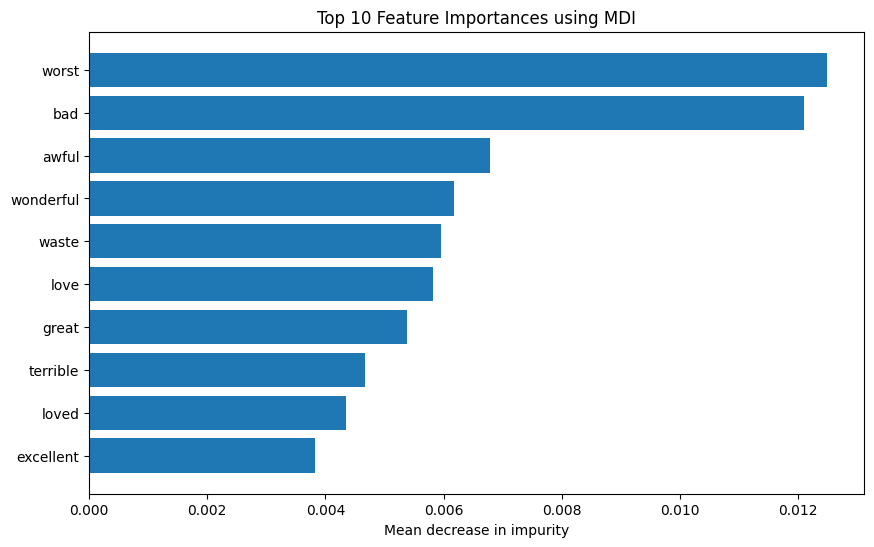

In [22]:
# Plot the feature importances
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'].head(10), feature_df['Importance'].head(10))
plt.gca().invert_yaxis()
plt.xlabel('Mean decrease in impurity')
plt.title('Top 10 Feature Importances using MDI')
plt.show()


## Predict sample reviews

In [24]:
# Predicting a new review
def preprocess_input_review(review):
    review = remove_tag(review)
    review = review.lower()
    review = remove_stopword(review)
    review = lemmatize_word(review)  
    return review

# Sample review input and prediction
rv = [input("Review: ")]
rv_processed = preprocess_input_review(rv[0])
rv_tf = tfidf_vect.transform([rv_processed])
rv_predict = best_rf.predict(rv_tf)
print(f"Predicted Sentiment: {encoder.inverse_transform(rv_predict)[0]}")

Review: This is the best movie i have ever seen
Predicted Sentiment: positive
